In [22]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


### Read the kaggle datasets as dataframes

In [23]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

In [24]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3658_01,Earth,True,G/593/S,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,0.0,Kelle Daughttley,True
1,6000_01,Mars,False,NaN,TRAPPIST-1e,19.0,False,781.0,0.0,295.0,613.0,0.0,Forms Bart,False
2,7045_01,Mars,False,D/222/P,55 Cancri e,19.0,False,1043.0,0.0,138.0,0.0,0.0,Range Bara,False
3,6415_01,Mars,True,F/1225/S,TRAPPIST-1e,51.0,False,0.0,0.0,0.0,0.0,0.0,Eang Potie,True
4,1669_01,Mars,False,F/317/S,TRAPPIST-1e,31.0,False,2436.0,0.0,147.0,16.0,0.0,Flams Spane,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4341,2140_01,Earth,False,F/424/P,TRAPPIST-1e,18.0,False,0.0,0.0,698.0,0.0,0.0,Andra Drakeekss,True
4342,3536_01,Europa,True,A/40/S,55 Cancri e,28.0,False,0.0,0.0,0.0,0.0,0.0,Zosmas Ineedeve,True
4343,6020_07,Earth,True,G/974/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,NaN,Tera Hanner,False
4344,3936_01,Earth,False,G/644/S,TRAPPIST-1e,24.0,False,3537.0,0.0,0.0,0.0,0.0,Carley Sancasey,False


In [25]:
test_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,3758_02,Earth,True,G/618/S,PSO J318.5-22,23.0,False,0.0,0.0,0.0,0.0,0.0,Oraine Litthews
1,2291_02,Earth,False,G/365/S,TRAPPIST-1e,36.0,False,3.0,0.0,435.0,8.0,277.0,Nancey Pittler
2,7052_01,Europa,NaN,E/469/S,55 Cancri e,27.0,False,0.0,0.0,0.0,0.0,0.0,Terons Stranbeate
3,8976_01,Earth,False,F/1737/S,TRAPPIST-1e,35.0,False,1.0,0.0,0.0,0.0,803.0,Tyrona Robbson
4,8456_01,Europa,True,C/280/P,55 Cancri e,33.0,False,0.0,0.0,0.0,0.0,0.0,Eltais Calazy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,2618_01,NaN,True,E/159/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Rassias Freednal
4343,7868_01,Earth,False,E/517/S,55 Cancri e,17.0,False,6256.0,0.0,0.0,1.0,21.0,Elly Hayerson
4344,6825_01,Mars,True,F/1306/S,NaN,30.0,False,0.0,0.0,0.0,0.0,0.0,Peefox Kinad
4345,5129_01,Earth,True,G/827/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Anthia Savaraldez


### Prepare and visualize the training data

In [26]:
train_data['PassengerId'] = train_data.PassengerId.str.replace('_' , '').astype(float)
transported_index = train_data[train_data["Transported"]].set_index("Transported")
not_transported_index = train_data[train_data["Transported"] == False].set_index("Transported")

In [27]:
transported_index.dtypes

PassengerId     float64
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

In [28]:
transported_index.shape

(2189, 13)

In [29]:
not_transported_index.shape

(2157, 13)

In [30]:
len(transported_index["Cabin"].unique())

1858

In [31]:
len(transported_index["Name"].unique())

2129

In [32]:
def plot_hist_subplots(col, title, bins="auto", discrete=None):
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,6))
    fig.suptitle(title)
    axes[0].set_title('Transported to new dimension')
    sns.histplot(data=transported_index[col], ax=axes[0], bins=bins, discrete=discrete)
    axes[1].set_title('Not transported to new dimension')
    sns.histplot(data=not_transported_index[col], ax=axes[1], bins=bins, discrete=discrete)

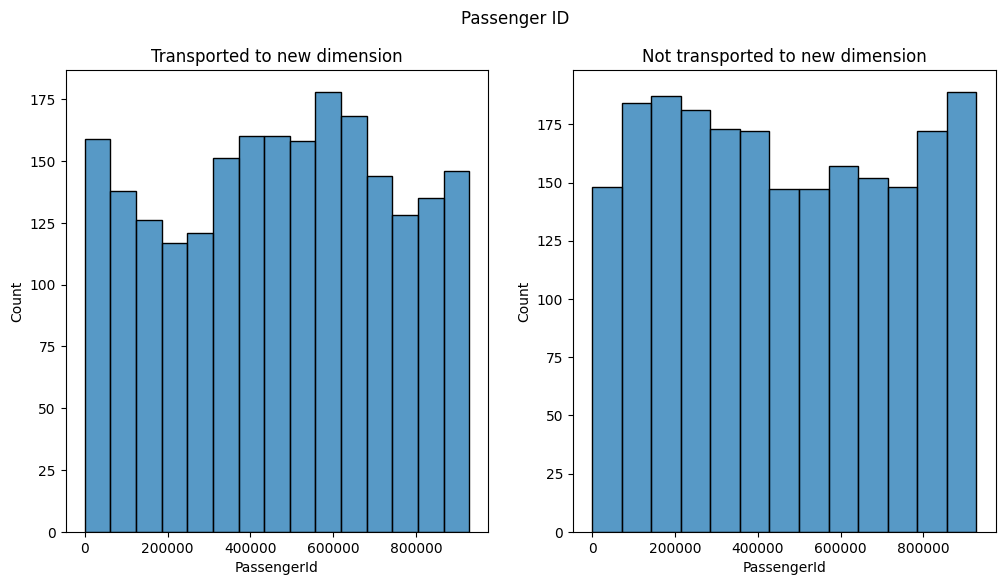

In [33]:
plot_hist_subplots(col="PassengerId", title="Passenger ID")

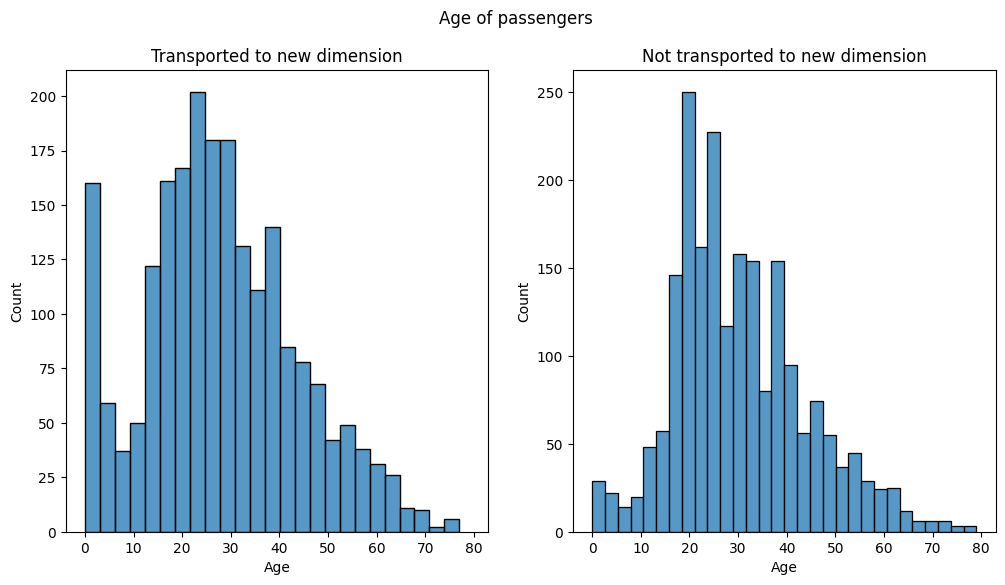

In [34]:
plot_hist_subplots(col="Age", title="Age of passengers")

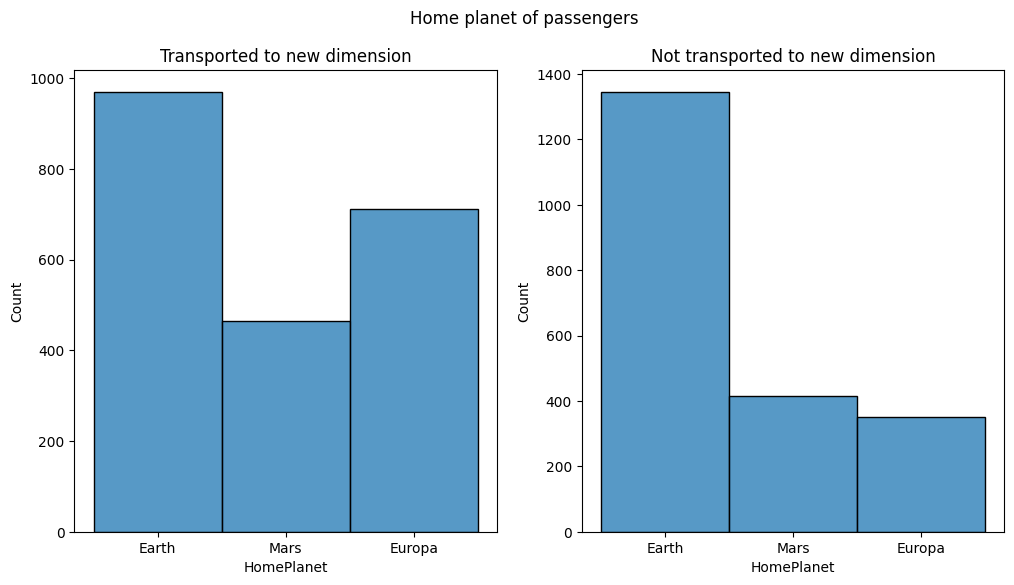

In [35]:
plot_hist_subplots(col="HomePlanet", title="Home planet of passengers")

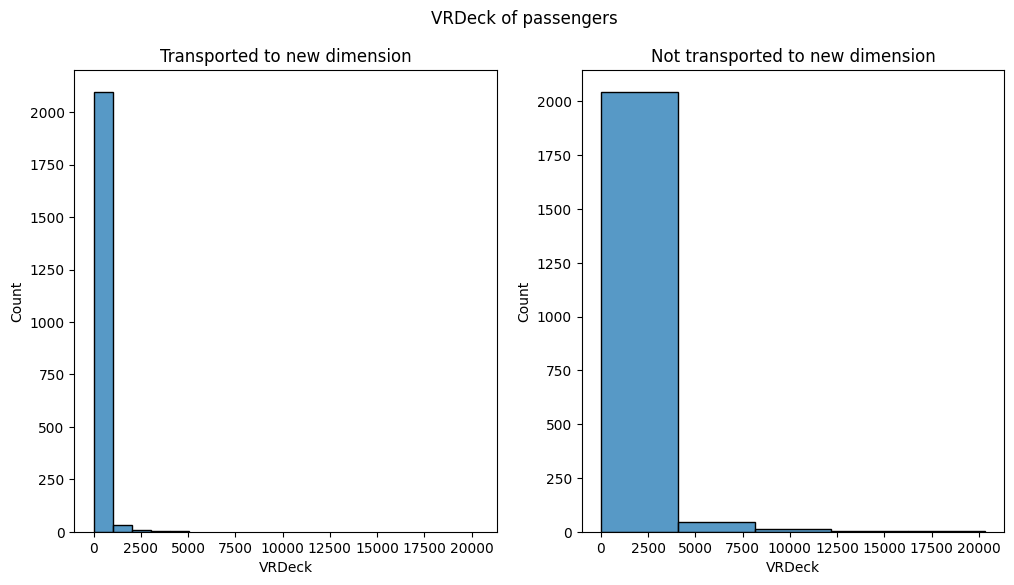

In [36]:
plot_hist_subplots(col="VRDeck", title="VRDeck of passengers", bins=5)

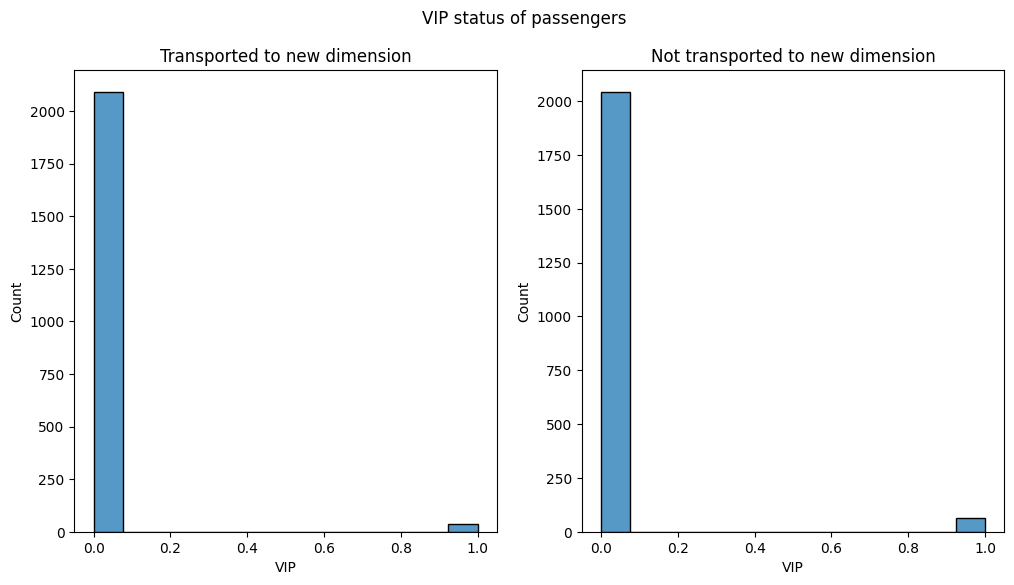

In [37]:
plot_hist_subplots(col="VIP", title="VIP status of passengers")

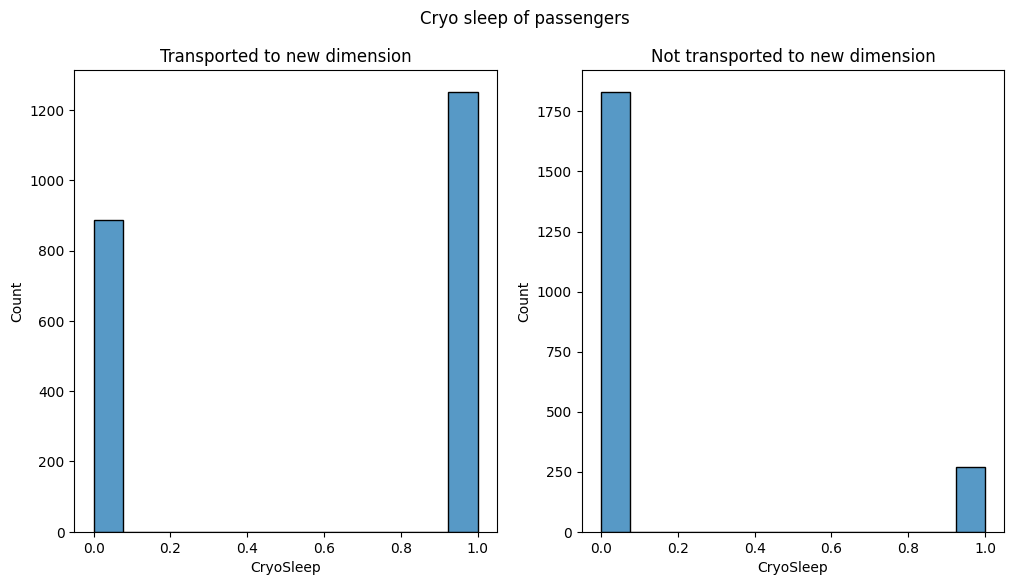

In [38]:
plot_hist_subplots(col="CryoSleep", title="Cryo sleep of passengers")

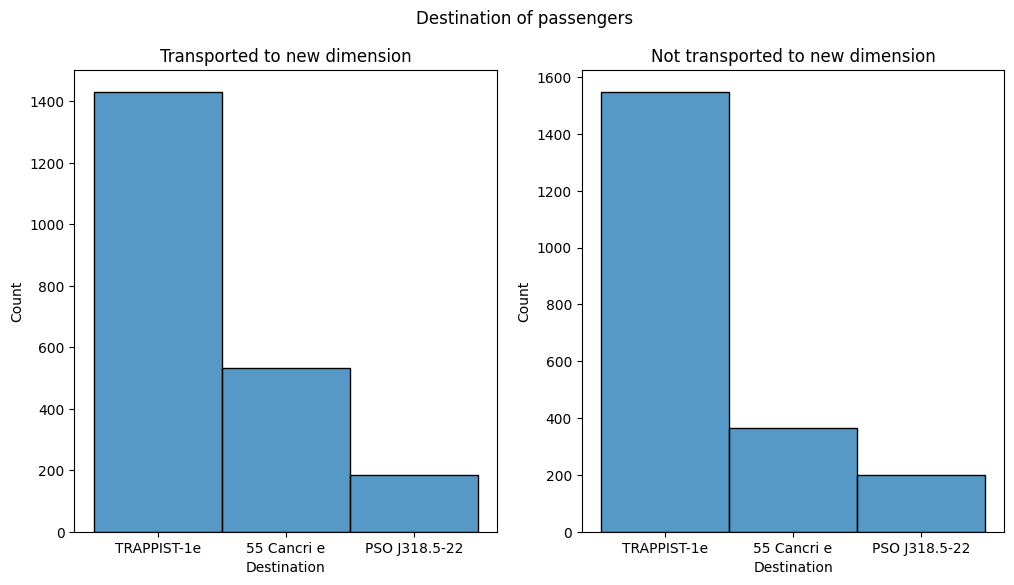

In [39]:
plot_hist_subplots(col="Destination", title="Destination of passengers")

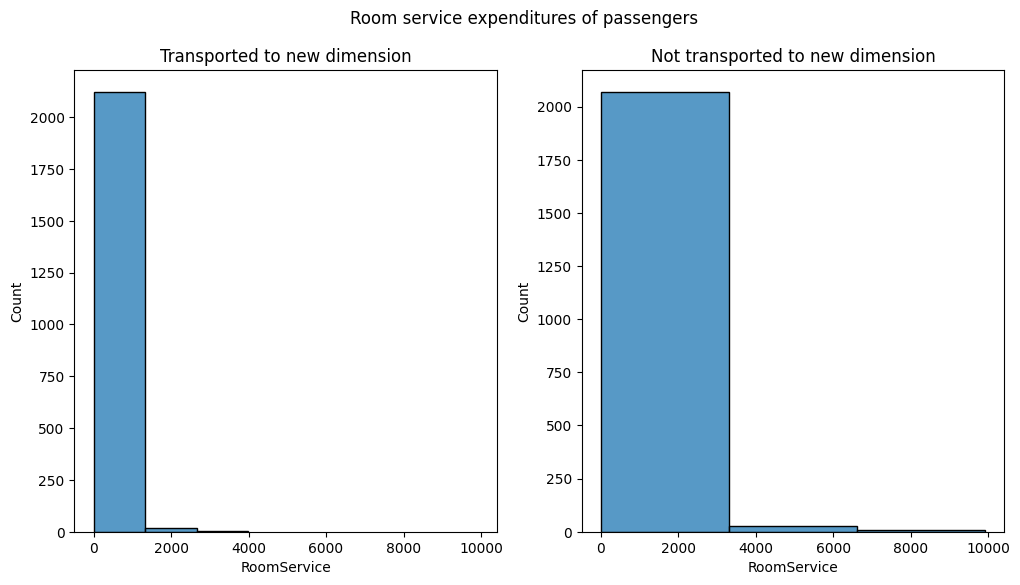

In [40]:
plot_hist_subplots(col="RoomService", title="Room service expenditures of passengers", bins=3)

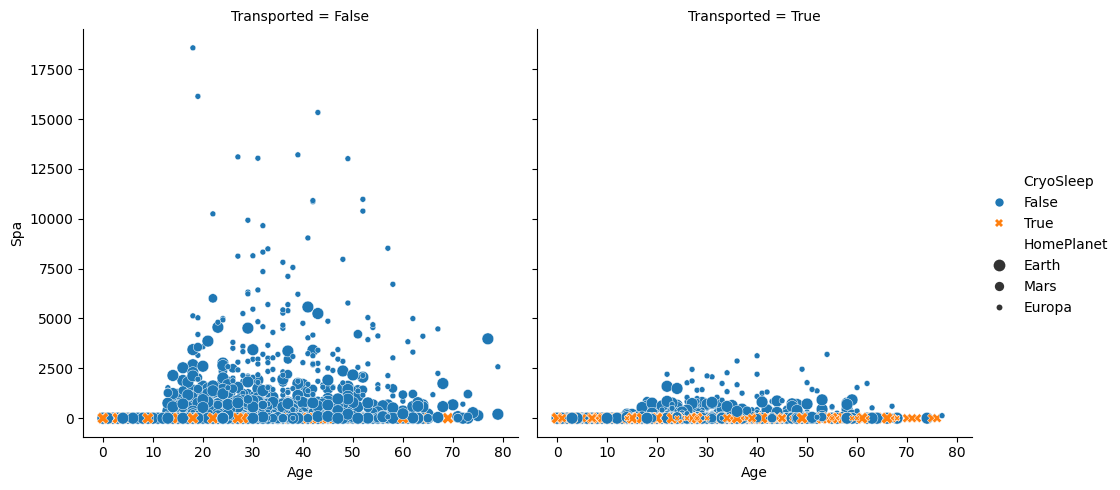

In [41]:
sns.relplot(data=train_data, x="Age", y="Spa", col="Transported", hue="CryoSleep", style="CryoSleep", size="HomePlanet")